# Protein folding 
Using our implementation of the AMBER forcefield for protein folding. 
Currently, it lacks water. 


## Todo 
1. GNN sims
2. CG sims
3. add water 

In [1]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../src/ to the sys path to access the coarsegrainer package
sys.path.append(pwd + '/../src/')

In [3]:
pwd

'/home/nima/__work/Coarse_graining/coarse_graining_code_2024_02/experiments'

In [4]:
# import time
# import collections

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
# import torch.nn.functional as F

# import openmm as omm
from openmm import app, unit


### import the coarse-graining module
import coarsegrainer as cg
from coarsegrainer.minimizer import EnergyMinimizer, CGMinimizer, GNNMinimizer
from coarsegrainer.energy import Energy, EnergyModule, LJ_potential, quadratic_potential 
from coarsegrainer.plotting import plot_line_3D, plot_graph

### protein folding module
import proteinfolding as pf

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

## Annealer module

In [5]:
# Define an annealing scheduler
from torch.optim.lr_scheduler import ExponentialLR

class AnnealingLR(ExponentialLR):
    def __init__(self, optimizer, lr_min, lr_max, epochs, last_epoch=-1):
        self.epochs = epochs
        self.epoch_counter = 0 # we use this to know when to stop decaying the LR
        self.get_decay_rate(lr_min, lr_max, epochs)
        super(AnnealingLR, self).__init__(optimizer, self.gamma, last_epoch)
    
    def get_decay_rate(self, lr_min, lr_max, epochs):
        self.gamma = (lr_min/lr_max)**(1/epochs)
    
    # we can redefine step to change the learning rate only before "epochs" epochs
    def step(self):
        if self.epoch_counter < self.epochs:
            self.epoch_counter += 1
            super(AnnealingLR, self).step()
        else:
            pass

# Loading protein

In [6]:
# pdb_id = '2WXC' # '2JOF' # '5AWL'
pdb_id = '2JOF'

pdb_dir = '../data/pdb/'
os.makedirs(pdb_dir, exist_ok=True) 

pdb_file = os.path.join(pdb_dir, pdb_id+'.pdb')

# check if pdb file exists, if not download it
if not os.path.isfile(pdb_file):
    pdb_file = pf.download_pdb_file(pdb_id, dir = pdb_dir)
    
prot = pf.Protein(pdb_file)


In [7]:
pdb = app.PDBFile(pdb_file)
modeller = app.Modeller(pdb.topology, pdb.positions)
forcefield = app.ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
modeller.addHydrogens(forcefield)
#self.modeller.deleteWater()
# modeller.addSolvent(forcefield, model="tip3p", padding=.05 * unit.nanometer)
system = forcefield.createSystem(modeller.topology)#, nonbondedMethod=PME, constraints=HBonds)


In [8]:
system.getNumParticles(), system.getNumForces()

(284, 5)

In [9]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = prot.node_positions.detach().numpy()*10 # 10x to go from nm to angstrom

pdb_orig_file = os.path.join(pdb_dir, f'orig-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_orig_file , 'w'))

In [10]:
import py3Dmol

# let's pick the pdb id of a small protein with two alpha helices:
# pdb_id = '2JOF' #  '1HLO'
# pdb_dir = '../data/pdb/'
# os.makedirs(pdb_dir, exist_ok=True) 
# pf.download_pdb_file(pdb_id, dir = pdb_dir)
# pdb_test_file = os.path.join(pdb_dir, pdb_id+'.pdb')

p_ = py3Dmol.view(data=pf.get_file_text(pdb_orig_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
# p_.addModel(pf.get_file_text(pdb_file), 'pdb')
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'


In [12]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Energy Minimization

In [13]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e0 # 1e-6

# learning rate
LR = 4e-3
DEVICE = 'cuda'


In [14]:
energy = pf.EnergyProtein(prot, device = DEVICE)
pdb_energy = energy(prot.node_positions.to(DEVICE)).item()
pdb_energy

50957.30078125

## Starting from PDB positions

In [15]:
# define the initial position
initial_pos = x = prot.node_positions.to(DEVICE)

energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', patience=PATIENCE, min_delta=MIN_DELTA)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n284_d3


In [16]:
h = energy_minimizer.train(10000)

Early stopping at step 4780


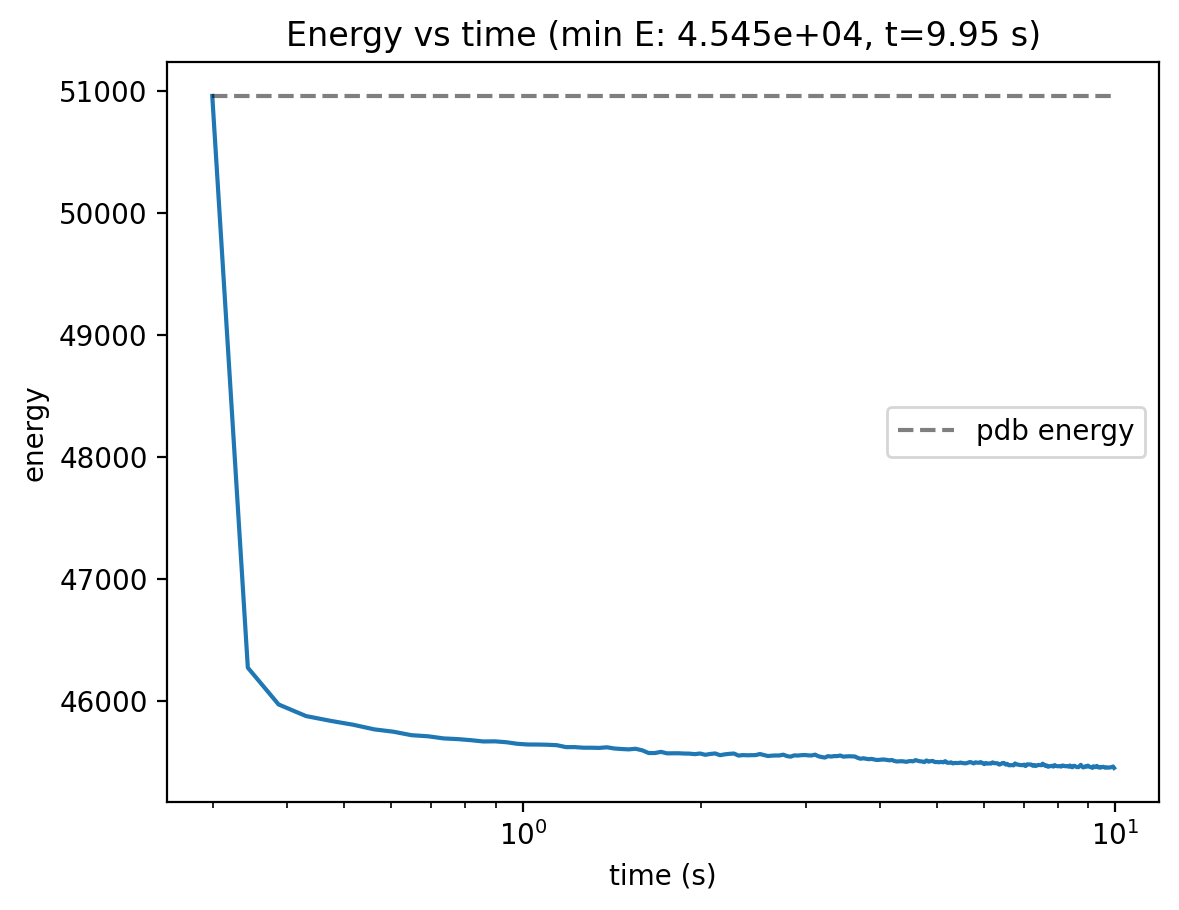

In [17]:
energy_minimizer.plot_history()
plt.yscale('linear')

plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

plt.plot([h['time'][0],np.sum(h['time'])], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')

plt.legend()

In [18]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.4804, 0.4744, 0.3383], device='cuda:0', grad_fn=<StdBackward0>)

In [19]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = f'./test-{pdb_id}.pdb'
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [20]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [21]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [22]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 1.411104771718164, 'CA': 1.0604180931431082, 'backbone': 1.0135614041394707}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Starting from Random Init

In [87]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e-1 # 1e0 # 1e-6

# learning rate
LR = 4e-3
DEVICE = 'cuda'


In [88]:
# define the initial position
x = torch.randn_like(prot.node_positions)
# scale x to have std = s*std of original positions
x = x * 1.5 * prot.node_positions.std(dim=0)
x = x.to(DEVICE)
initial_pos = x

energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', patience=PATIENCE, min_delta=MIN_DELTA)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n284_d3


In [89]:
energy_minimizer.min_delta

0.1

In [90]:
N = 100
drop_rate = 40 #10
annealer = AnnealingLR(energy_minimizer.optimizer, 
                    lr_max=energy_minimizer.lr, 
                    lr_min=energy_minimizer.lr/drop_rate, 
                    epochs=N)


In [91]:
annealer.gamma

0.9637833073548235

In [92]:
relax_counter = 10
for epoch in range(2*N):
    h = energy_minimizer.train(500)
    # also print the current lr
    
    c = energy_minimizer.early_stop.patience_counter
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end=' ')
    annealer.step()
    print(f'FG lr: {annealer.get_last_lr()[0]:.2e}', end = '\r')

    if energy_minimizer.early_stopping_triggered:
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

Early stopping at step 440, time: 46.46 s, pat:7, FG lr: 6.81e-044
epoch: 48, energy: 45420.5, time: 47.34 s, pat:20, FG lr: 6.56e-04
relaxing 9
Early stopping at step 480, time: 52.17 s, pat:18, FG lr: 5.46e-04
epoch: 54, energy: 45418.5, time: 53.14 s, pat:20, FG lr: 5.26e-04
relaxing 8
Early stopping at step 440, time: 64.76 s, pat:7, FG lr: 3.38e-044
epoch: 67, energy: 45415.8, time: 65.62 s, pat:20, FG lr: 3.26e-04
relaxing 7
Early stopping at step 440
epoch: 68, energy: 45415.7, time: 66.51 s, pat:20, FG lr: 3.14e-04
relaxing 6
Early stopping at step 460
epoch: 69, energy: 45415.5, time: 67.43 s, pat:20, FG lr: 3.02e-04
relaxing 5
Early stopping at step 400time: 70.31 s, pat:13, FG lr: 2.71e-0404
epoch: 73, energy: 45415, time: 71.12 s, pat:20, FG lr: 2.61e-04
relaxing 4
Early stopping at step 480, time: 72.08 s, pat:7, FG lr: 2.51e-04
epoch: 75, energy: 45414.7, time: 73.05 s, pat:20, FG lr: 2.42e-04
relaxing 3
Early stopping at step 400, time: 92.39 s, pat:7, FG lr: 1.16e-044
e

In [93]:
h = energy_minimizer.train(20000)

Early stopping at step 400


Text(0.5, 1.0, 'Energy vs time (min E: 4.541e+04, t=97.53 s)')

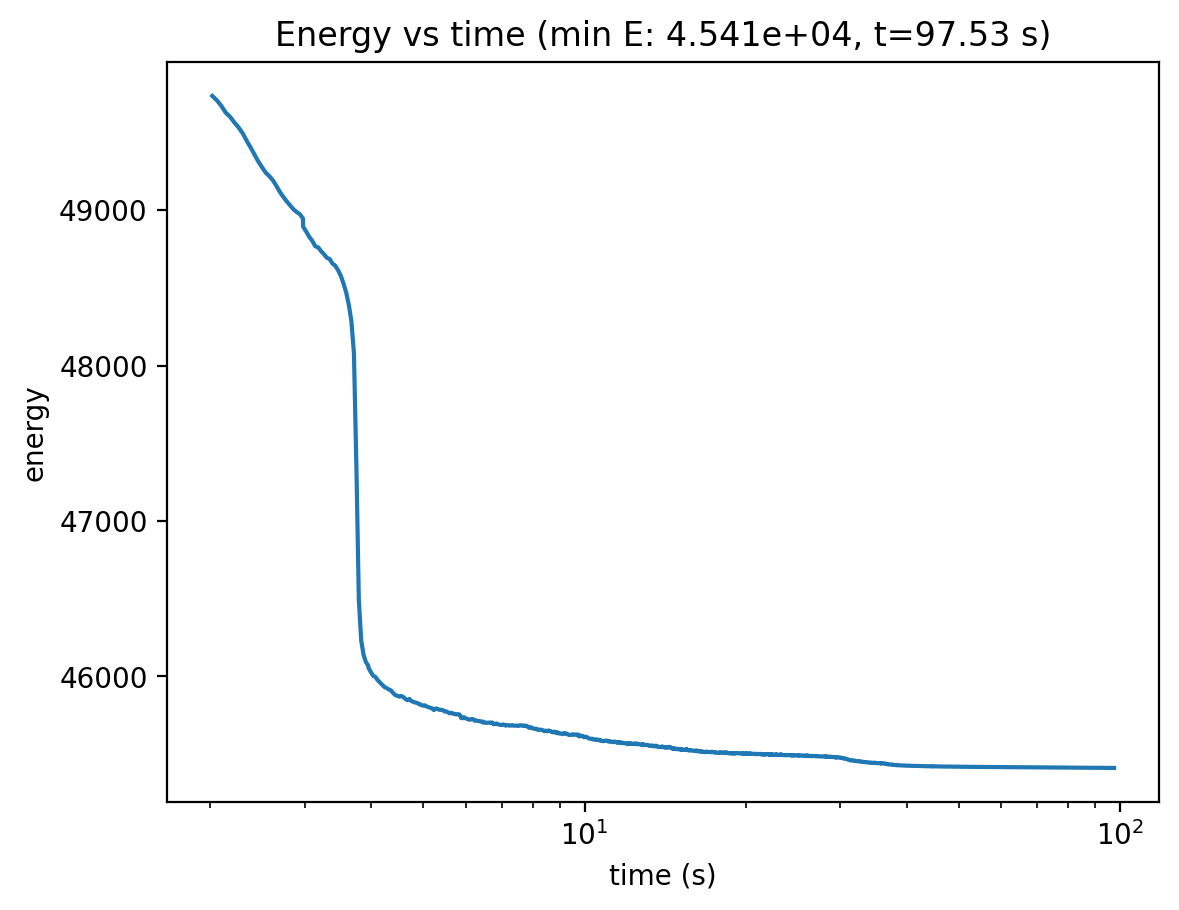

In [94]:
h = energy_minimizer.history
t = np.cumsum(h['time'])

k = 50

energy_minimizer.plot_history(k)


plt.yscale('linear')
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

# plt.plot(t[[k,-1]], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')


In [95]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.3639, 0.4860, 0.4352], device='cuda:0', grad_fn=<StdBackward0>)

In [96]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = f'./test-{pdb_id}.pdb'
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [98]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [99]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [110]:
# prot.harmonic_bond_data['equilibrium_length']

# GNN

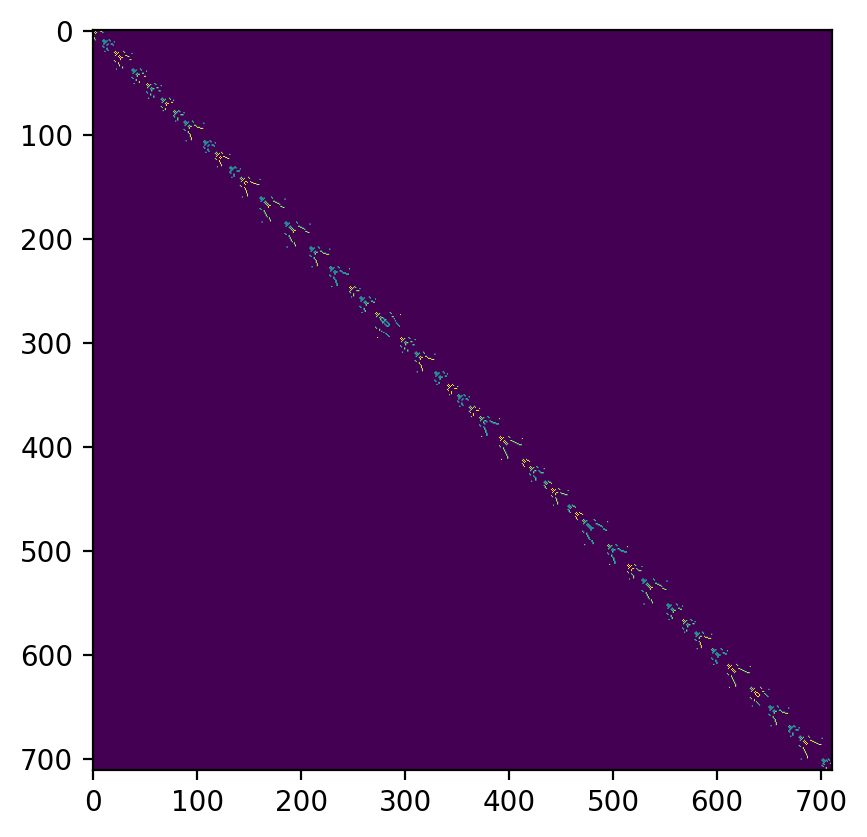

In [44]:
plt.imshow(V(prot.adjacency_matrix))

In [45]:
# to initialize random positions, we can 
# estimate the average volume occupied by each atom
# when the atoms are in a regular grid with
# the same distance between them. 
# we set this distance to 1.5A (average bond length)

# the volume occupied by each atom is a sphere with radius 1.5A
r0 = 0.15 # nm
v0 = 4/3*np.pi*r0**3
# total volume occupied by all atoms
vn = len(prot.node_positions)*v0
init_radius = (vn*3/4/np.pi)**(1/3)
init_radius


1.3387961639331505

In [235]:
MIN_DELTA = 1e-2
PATIENCE = 20
DEVICE = 'cuda'

In [237]:
from coarsegrainer.GNN import GNNReparam

# hidden dimension
h = 300
A = prot.adjacency_matrix.to(DEVICE)
n = len(A)
d = 3
init_scaling = 6 #1.5
gnn_reparam = GNNReparam([h, h//1, h//1, d], A=A,
                        bias=True, activation=torch.nn.Tanh(), output_init_sigma= init_scaling*init_radius, 
                        device=DEVICE, residual=True)
print(f"std after rescaling {gnn_reparam().std().item():.3g}")

gnn_minimizer = GNNMinimizer(energy, initial_pos, gnn_reparam, optimizer_type='Adam',
    lr=4e-4, lr_gnn=1e-4,
    # lr=4e-3, lr_gnn=1e-4,
    # lr=1e-3, lr_gnn=1e-3,
    # lr=2*LR, lr_gnn=4e-3,
    clamp_grads=1e-2, log_step=20, log_pos_step=0, 
    log_dir='../results/logs', log_name=f'GNN_protein_{pdb_id}_',
    patience=PATIENCE, min_delta=MIN_DELTA, 
    gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e0)


std after rescaling 8.02
Using Adam optimizer
Log name: GNN_protein_2WXC_
Logging to: ../results/logs/GNN_protein_2WXC__n711_d3
Using Adam optimizer


In [238]:
(gnn_reparam().std(), gnn_minimizer.get_x().std())

(tensor(8.0197, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(8.0197, device='cuda:0', grad_fn=<StdBackward0>))

In [239]:
N = 100
drop_rate = 40 #10
annealer_gnn = AnnealingLR(gnn_minimizer.optimizer_gnn, 
                    lr_max=gnn_minimizer.lr_gnn, 
                    lr_min=gnn_minimizer.lr_gnn/drop_rate, 
                    epochs=N)

annealer_fg = AnnealingLR(gnn_minimizer.optimizer_fg, 
                    lr_max=gnn_minimizer.lr, 
                    lr_min=gnn_minimizer.lr/drop_rate, 
                    epochs=N)

In [271]:
gnn_minimizer.min_delta *= 10

In [272]:
# annealer_fg.epochs = 200

In [274]:
relax_counter = 10
for epoch in range(2*N):
    h = gnn_minimizer.train(500)
    # also print the current lr
    
    c = gnn_minimizer.early_stop.patience_counter
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end=' ')
    
    if not gnn_minimizer.fine_grained:
        annealer_gnn.step()
        print(f'GNN lr: {annealer_gnn.get_last_lr()[0]:.2e}', end = '\r')
    else:
        annealer_fg.step()
        print(f'FG lr: {annealer_fg.get_last_lr()[0]:.2e}', end = '\r')
        
    if gnn_minimizer.early_stopping_triggered:
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

Early stopping at step 400
Starting fine-graining


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Early stopping at step 460 time: 657.20 s, pat:9, FG lr: 4.06e-05
epoch: 62, energy: 108335, time: 658.15 s, pat:20, FG lr: 3.92e-05
relaxing 9
Early stopping at step 480 time: 664.08 s, pat:1, FG lr: 3.14e-05
epoch: 69, energy: 108334, time: 665.07 s, pat:20, FG lr: 3.02e-05
relaxing 8
Early stopping at step 420 time: 675.00 s, pat:2, FG lr: 2.09e-055
epoch: 80, energy: 108333, time: 675.86 s, pat:20, FG lr: 2.02e-05
relaxing 7
Early stopping at step 460 time: 680.81 s, pat:7, FG lr: 1.68e-055
epoch: 86, energy: 108333, time: 681.76 s, pat:20, FG lr: 1.62e-05
relaxing 6
Early stopping at step 480 time: 682.75 s, pat:18, FG lr: 1.56e-05
epoch: 88, energy: 108333, time: 683.75 s, pat:20, FG lr: 1.50e-05
relaxing 5
Early stopping at step 400 time: 684.73 s, pat:9, FG lr: 1.45e-05
epoch: 90, energy: 108333, time: 685.56 s, pat:20, FG lr: 1.39e-05
relaxing 4
Early stopping at step 400 time: 686.55 s, pat:8, FG lr: 1.34e-05
epoch: 92, energy: 108333, time: 687.37 s, pat:20, FG lr: 1.29e-05


In [275]:
# gnn_minimizer.start_fine_graining()

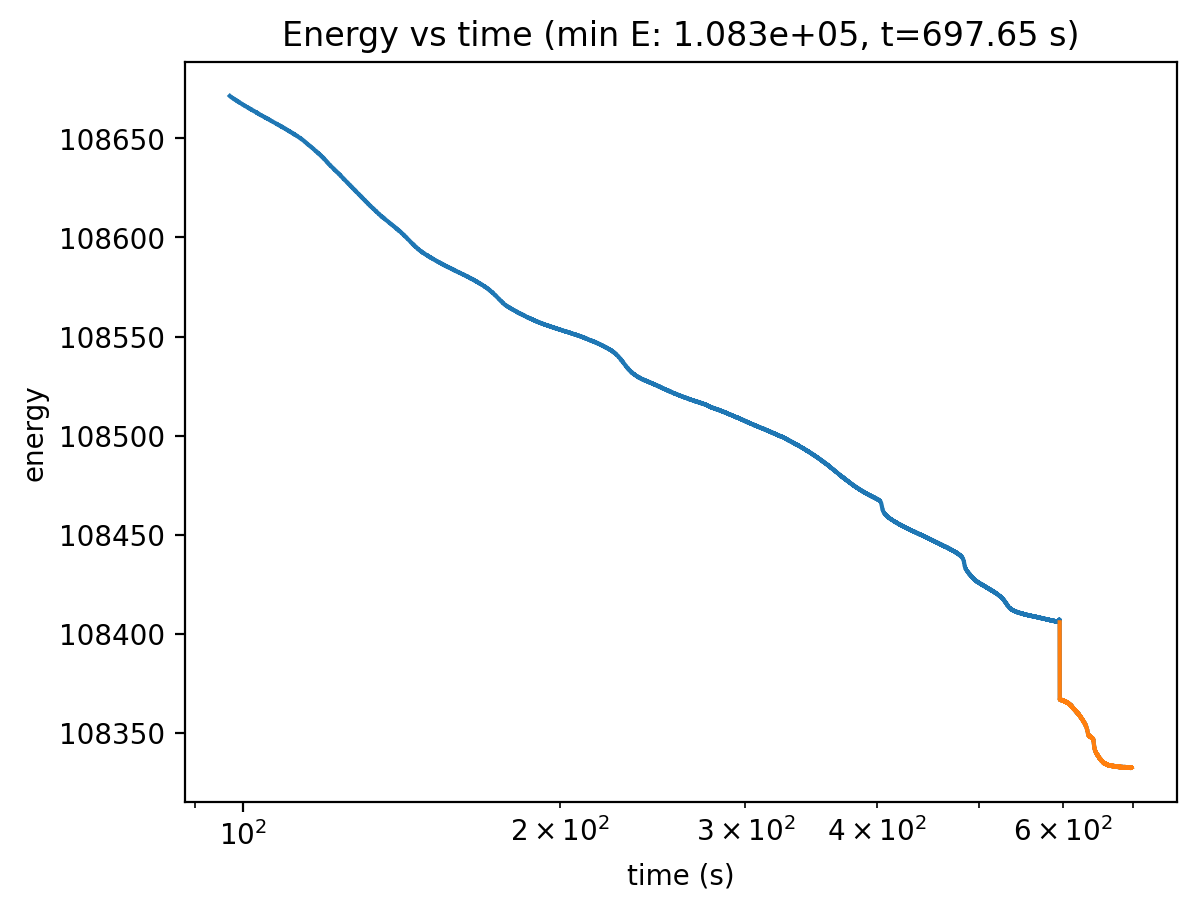

In [276]:
gnn_minimizer.plot_history(start=2000)
try:
    gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps+0)
except:
    pass
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')
plt.yscale('linear')


In [277]:
xf = gnn_minimizer.get_x()
xf.std(dim=0)

tensor([0.8213, 0.7423, 0.5675], device='cuda:0', grad_fn=<StdBackward0>)

In [278]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = f'./test-GNN-{pdb_id}.pdb'
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [279]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [267]:
import py3Dmol

# let's pick the pdb id of a small protein with two alpha helices:
# pdb_id = '2JOF' #  '1HLO'
# pdb_dir = '../data/pdb/'
# os.makedirs(pdb_dir, exist_ok=True) 
# pf.download_pdb_file(pdb_id, dir = pdb_dir)
# pdb_test_file = os.path.join(pdb_dir, pdb_id+'.pdb')

p_ = py3Dmol.view(data=pf.get_file_text(pdb_orig_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [162]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [66]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [163]:
p_.setStyle({'stick': {}})
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# RMSD

In [164]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [165]:
pdb_orig_file, pdb_test_file

('../data/pdb/orig-2WXC.pdb', './test-GNN-2WXC.pdb')

In [13]:
# pdb_orig_file, pdb_test_file = ('../data/pdb/orig-2WXC.pdb', './test-GNN-2WXC.pdb')

In [14]:
from Bio.PDB import PDBParser, Superimposer

# Parse the structures
parser = PDBParser()
structure1 = parser.get_structure(f"orig-{pdb_id}", pdb_orig_file)
structure2 = parser.get_structure(f"GNN-{pdb_id}", pdb_test_file)

# Get the atoms from each structure
atoms1 = list(structure1.get_atoms())
atoms2 = list(structure2.get_atoms())

# Make sure the two proteins have the same number of atoms
assert len(atoms1) == len(atoms2), "Proteins have different numbers of atoms"

# Create a Superimposer object
super_imposer = Superimposer()

# Apply the superimposition on the atom coordinates
super_imposer.set_atoms(atoms1, atoms2)

# Print the RMSD
print("RMSD:", super_imposer.rms)

RMSD: 12.409642767050101


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 715
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 715
  warnings.warn(


In [15]:
from Bio.PDB import PDBParser, Superimposer

# Define a function to filter only backbone atoms
def get_backbone_atoms(structure):
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    if atom.get_name() in ['N', 'CA', 'C']:
                        yield atom

# Parse the structures
parser = PDBParser()
structure1 = parser.get_structure(f"orig-{pdb_id}", pdb_orig_file)
structure2 = parser.get_structure(f"GNN-{pdb_id}", pdb_test_file)

# Get only the backbone atoms from each structure
backbone_atoms1 = list(get_backbone_atoms(structure1))
backbone_atoms2 = list(get_backbone_atoms(structure2))

# Make sure the two proteins have the same number of backbone atoms
assert len(backbone_atoms1) == len(backbone_atoms2), "Proteins have different numbers of backbone atoms"

# Create a Superimposer object
super_imposer = Superimposer()

# Apply the superimposition on the backbone atom coordinates
super_imposer.set_atoms(backbone_atoms1, backbone_atoms2)

# Print the RMSD
print("RMSD:", super_imposer.rms)


RMSD: 10.841719543769209


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 715
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 715
  warnings.warn(


In [269]:
from Bio.PDB import PDBIO

# Apply the rotation and translation to the second structure
super_imposer.apply(structure2.get_atoms())

# Write the superimposed structure to a new PDB file
io = PDBIO()
# io.set_structure(structure1)
# pdb_orig_file = f'./superimposed-GNN-{pdb_id}.pdb'
# io.save(pdb_superimposed_file)
io.set_structure(structure2)
pdb_superimposed_file = os.path.join(pdb_dir, f'superimposed-GNN-{pdb_id}.pdb')
io.save(pdb_superimposed_file)

In [270]:
import py3Dmol

# Read the PDB file
with open(pdb_superimposed_file, "r") as f: 
    pdb_super = f.read()
with open(pdb_orig_file, "r") as f: 
    pdb_orig = f.read()

# Create a viewer and add the structure
viewer = py3Dmol.view()
viewer.addModel(pdb_super, "pdb")
viewer.addModel(pdb_orig, "pdb")

# Set some display options
# viewer.setStyle({'stick': {}})
# display the protein as a cartoon
# viewer.setStyle({'cartoon': {'color':'spectrum'}})
viewer.setStyle({'model': 0}, {'cartoon': {'color': 'spectrum'}})  # original structure in blue
viewer.setStyle({'model': 1}, {'cartoon': {'color': 'spectrum', 'opacity': 0.6}})  # superimposed structure in semi-transparent red

viewer.zoomTo()

# Show the viewer
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [168]:
import py3Dmol

# Read the PDB file
with open(pdb_superimposed_file, "r") as f: 
    pdb_super = f.read()
with open(pdb_orig_file, "r") as f: 
    pdb_orig = f.read()

# Create a viewer and add the structure
viewer = py3Dmol.view()
viewer.addModel(pdb_super, "pdb")
viewer.addModel(pdb_orig, "pdb")

# Set some display options
# viewer.setStyle({'stick': {}})
# display the protein as a cartoon
# viewer.setStyle({'cartoon': {'color':'spectrum'}})
viewer.setStyle({'model': 0}, {'cartoon': {'color': 'spectrum'}})  # original structure in blue
viewer.setStyle({'model': 1}, {'cartoon': {'color': 'spectrum', 'opacity': 0.6}})  # superimposed structure in semi-transparent red

viewer.zoomTo()

# Show the viewer
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [145]:
import py3Dmol

# Read the PDB file
with open(pdb_superimposed_file, "r") as f: 
    pdb_super = f.read()
with open(pdb_orig_file, "r") as f: 
    pdb_orig = f.read()

# Create a viewer and add the structure
viewer = py3Dmol.view()
viewer.addModel(pdb_super, "pdb")
viewer.addModel(pdb_orig, "pdb")

# Set some display options
# viewer.setStyle({'stick': {}})
# display the protein as a cartoon
# viewer.setStyle({'cartoon': {'color':'spectrum'}})
viewer.setStyle({'model': 0}, {'stick': {'color': 'blue'}})  # original structure in blue
viewer.setStyle({'model': 1}, {'stick': {'color': 'red', 'opacity': 0.6}})  # superimposed structure in semi-transparent red

viewer.zoomTo()

# Show the viewer
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# CG

In [15]:
energy

EnergyModule object with energy function energy

In [14]:
# to initialize random positions, we can 
# estimate the average volume occupied by each atom
# when the atoms are in a regular grid with
# the same distance between them. 
# we set this distance to 1.5A (average bond length)

# the volume occupied by each atom is a sphere with radius 1.5A
r0 = 0.15 # nm
v0 = 4/3*np.pi*r0**3
# total volume occupied by all atoms
vn = len(prot.node_positions)*v0
init_radius = (vn*3/4/np.pi)**(1/3)
init_radius
k = 10
d = 3
n = len(prot.node_positions)
init_sigma = 2*init_radius

print(f'init radius: {init_radius:.3f}A, init sigma: {init_sigma:.3f}A')

init radius: 1.339A, init sigma: 2.678A


In [15]:
with torch.no_grad():
    x_samples = (init_sigma*torch.randn(k, n, d)*torch.linspace(1e-2, 2e-1, k)[:, None, None]).to(DEVICE)

x_samples.shape

torch.Size([10, 711, 3])

In [2]:
import torch

In [3]:
torch.__version__

'2.3.0'

In [16]:

class CoarseGrainer:
    def __init__(self, energy_func, num_cg_modes=None):
        """Defines Coarse-grained (CG) variables using the normal modes of the energy function.
        The normal modes are related to the force constant matrix of the particle system.
        The force constant matrix is the Hessian of the energy function with respect to the coordinates.
        The Hessian is a 4-tensor with shape (N, d, N, d).
        The first two indices correspond to the coordinates of the first atom, 
        and the second pair to the second atom. 
        
        We take the norm of the Hessian over the spatial coordinates of both atoms 
        to define the force constant matrix (symmetric of shape (N,N)) for the system. 
        The force constant for a bond is the curvature of the energy at the equilibrium bond length
        
        We consider the force constant matrix as the adjacency matrix of a graph.
        We define the graph laplacian as the diagonal matrix of the row sums of 
        the adjacency matrix minus the adjacency matrix.
        
        Then, to define the CG variables, we compute the eigenvectors of the graph laplacian.
        
        Args:
            energy (_type_): The energy function of the particle system. 
                It should take the coordinates as its first input, e.g. energy(x), and return a number.
            num_cg_modes (int, optional): the number of CG modes to compute. 
                If not specified, N/3 modes will be computed. Defaults to None.
        """
        self.energy = energy_func
        # define the Hessian of the energy function with respect to the coordinates
        self.get_hessian_func()
        self.num_cg_modes = num_cg_modes
        
    def get_hessian_func(self):
        self.hessian = torch.func.hessian(self.energy, argnums=0)

    # make the hessian norm over dims 1,3 a function
    def get_force_constant_matrix(self, x):
        """Compute the force constant matrix of the system"""
        # compute the Hessian
        with torch.no_grad():
            H = self.hessian(x).norm(dim=(1,3))
        return H
    
    def get_sample_force_constant_matrix(self, x_samples):
        """Compute the force constant matrix of the system"""
        # make sure x_samples is a tensor with at least 3 dimensions
        assert len(x_samples.shape) >= 2
        if len(x_samples.shape) == 2:
            x_samples = x_samples.unsqueeze(0)
            
        # compute the Hessian for each ro in x_samples and take the mean over samples
        # H = torch.stack([self.get_force_constant_matrix(x) for x in x_samples]).mean(dim=0)
        # for memory efficiency, we can compute the Hessian for each row in x_samples and take the mean
        with torch.no_grad():
            H = torch.zeros(x_samples.shape[-2], x_samples.shape[-2]).to(x_samples.device)
            for x in x_samples:
                print(x.shape)
                H += self.get_force_constant_matrix(x)
            H /= x_samples.shape[0]
        return H
    
    def get_heat_capacity(self, x_samples):
        """Compute the heat capacity of the system"""
        H = self.get_sample_force_constant_matrix(x_samples)
        return H.trace()
    
    def get_laplacian(self, A):
        return torch.diag(A.sum(dim=1)) - A
    
    def get_cg_modes(self, x_samples, k=None, update_force_constant_matrix=True):
        if k is None:
            if self.num_cg_modes is None:
                k = np.ceil(x_samples.shape[-2]/3).astype(int)
                warnings.warn(f'k not specified. Using k={k}')
            else:
                k = self.num_cg_modes
        # initialize the force constant matrix, if not already initialized
        if not hasattr(self, 'force_constant_matrix'):
            self.force_constant_matrix = torch.zeros(x_samples.shape[-2], x_samples.shape[-2]).to(x_samples.device)
        # also, if update_force_constant_matrix is True, we will update the force constant matrix
        # if it is False, we will reinitialize the force constant matrix
        if not update_force_constant_matrix:
            self.force_constant_matrix = torch.zeros(x_samples.shape[-2], x_samples.shape[-2]).to(x_samples.device)
        # time to compute the CG modes
        t0 = time.time()
        # compute the force constant matrix
        self.force_constant_matrix += self.get_sample_force_constant_matrix(x_samples)
        print(f'force constant matrix computed in {time.time()-t0:.2f} seconds')
        t0 = time.time()
        # compute the spectrum of the Laplacian of the force constant matrix
        self.get_L_spectrum()
        print(f'spectrum of the Laplacian computed in {time.time()-t0:.2f} seconds')
        # pick the k eigenvectors with the lowest eigenvalues
        self.cg_idx = torch.argsort(self.L_eigenvalues.abs())[:k]
        # CG modes: get the k eigenvectors with the lowest eigenvalues
        self.cg_modes = self.L_eigenvectors[:, self.cg_idx]
        # also, store the eigenvalues coming from the force constant matrix
        # to do so, we will first find which eigenvectors correspond to the CG modes
        # then we will pick the eigenvalues corresponding to the CG modes
        # overlap = torch.einsum('ij,jk->ik', self.cg_modes.T, self.A_eigenvectors)
        # self.cg_eigenvalues = self.A_eigenvalues[overlap.argmax(dim=1)]
        # self.cg_eigenvalues = self.A_eigenvalues[self.cg_idx]
        # instead of eigenvalues, it would be more accurate to 
        # use the expectation value of the force constant matrix w.r.t. the CG modes
        self.cg_eigenvalues = (self.cg_modes.T @ self.force_constant_matrix @ self.cg_modes).diagonal()
        
    def get_L_spectrum(self):
        # compute the graph laplacian
        self.L = self.get_laplacian(self.force_constant_matrix)
        # compute the eigenvectors of the graph laplacian
        self.L_eigenvalues, self.L_eigenvectors = torch.linalg.eigh(self.L)
        # also compute spectrum of the force constant matrix (will use this for scaling the CG modes)
        self.A_eigenvalues, self.A_eigenvectors = torch.linalg.eigh(self.force_constant_matrix)
    
    def get_cg_variables(self, x):
        """compute the CG variables"""
        return self.cg_modes.T @ x
    
    def get_cg_energy(self, x):
        """compute the CG energy"""
        return self.energy(self.get_cg_variables(x))
    
    def get_cg_force_constant_matrix(self):
        """compute the CG force constant matrix"""
        return self.cg_modes.T @ self.force_constant_matrix @ self.cg_modes
    
    def get_cg_hessian(self, x):
        """compute the CG Hessian. Recall that the Hessian is shape (N,d,N,d)
        we want to compute the Hessian with respect to the CG variables
        the CG variables are shape (N,k)
        the CG Hessian is shape (k,d,k,d)"""
        # we can compute the CG Hessian by contracting the Hessian with the CG modes
        return torch.einsum('ijkl,im,kn->mjnl', self.hessian(x), self.cg_modes, self.cg_modes)
    
    def cg_reparametrize(self, x):
        """Reparametrize the coordinates using the CG variables"""
        z = self.get_cg_variables(x)
        # We want to define the CG variables z as the new optimization variables
        # we will detach z from the graph and set requires_grad=True
        # this will make z the new optimization variables
        return z.clone().detach().requires_grad_(True)
        
    def get_x_from_cg(self, z):
        """Get the coordinates from the CG variables"""
        return self.cg_modes @ z
    
    # Example usage of the CoarseGrainer class
    # cg = CoarseGrainer(energy_func=energy, num_cg_modes=7)
    # cg.get_cg_modes(x)
    # cg.cg_modes.shape
    


In [17]:
x_samples.shape

torch.Size([10, 711, 3])

In [18]:
cg_prot = CoarseGrainer(energy, num_cg_modes=n//2)

In [19]:
cg_prot.get_cg_modes?

Signature: cg_prot.get_cg_modes(x_samples, k=None, update_force_constant_matrix=True)
Docstring: <no docstring>
File:      /tmp/ipykernel_132356/3474712012.py
Type:      method

In [30]:
import time
t0 = time.time()
# produce k samples with different std for x


cg_prot.get_cg_modes(x_samples)
cg_time = time.time() - t0
print(f'CG time {cg_time:.3g}')

torch.Size([711, 3])


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.05 GiB. GPU 

In [23]:
# clear pytorch GPU cache 
torch.cuda.empty_cache()

In [20]:
for x in x_samples:
    dx = (x[None] - x[:,None]).norm(dim=-1)
    print(dx.shape)
    # print(cg_prot.get_cg_energy(x))

torch.Size([711, 711])
torch.Size([711, 711])
torch.Size([711, 711])
torch.Size([711, 711])
torch.Size([711, 711])
torch.Size([711, 711])
torch.Size([711, 711])
torch.Size([711, 711])
torch.Size([711, 711])
torch.Size([711, 711])


In [21]:
f = lambda x: (x[None] - x[:,None]).norm(dim=-1).sum()
H = torch.func.hessian(f, argnums=0)

In [24]:
a = torch.randn(700,3,700,3).to(DEVICE)

In [22]:
H(x).shape

OutOfMemoryError: CUDA out of memory. Tried to allocate 12.05 GiB. GPU 

In [25]:
# import torch
# x = torch.randn(700, 3, requires_grad=True)
dist = lambda x: (x[None] - x[:,None]).norm(dim=-1).sum()
x.requires_grad = True
grads = torch.autograd.grad(dist(x), x, create_graph=True)[0]
hessian = torch.zeros(n, d, n, d)
for i in range(n):
    for j in range(d):
        hessian[i, j] = torch.autograd.grad(grads[i, j].detach(), x, retain_graph=True)[0]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [27]:
# import torch

x = torch.randn(700, 3, requires_grad=True)
dist = lambda x: (x[None] - x[:,None]).norm(dim=-1).sum()

grads = torch.autograd.grad(dist(x), x, create_graph=True)[0]
hessian = torch.zeros(700, 3, 700, 3)
for i in range(700):
    for j in range(3):
        hessian[i, j] = torch.autograd.grad(grads[i, j], x, retain_graph=True)[0]


In [28]:
# import torch

# x = torch.randn(700, 3, requires_grad=True)
x = x_samples[0]
x.requires_grad = True

grads = torch.autograd.grad(energy(x), x, create_graph=True)[0]
hessian = torch.zeros(n,d,n,d)
for i in range(n):
    for j in range(d):
        hessian[i, j] = torch.autograd.grad(grads[i, j], x, retain_graph=True)[0]


In [35]:
x

tensor([[ 0.0128,  0.0246, -0.0188],
        [ 0.0035, -0.0289, -0.0354],
        [-0.0237,  0.0196,  0.0438],
        ...,
        [-0.0065,  0.0221, -0.0104],
        [-0.0165,  0.0251,  0.0228],
        [ 0.0124,  0.0026, -0.0295]], device='cuda:0', requires_grad=True)

In [29]:
hessian.shape

torch.Size([711, 3, 711, 3])

In [32]:
H= V(hessian.norm(dim=(1,3)))

In [33]:
H

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [34]:
hessian

tensor([[[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],
          ...,
          [nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],
          ...,
          [nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],
          ...,
          [nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]]],


        [[[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],
          ...,
          [nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],
          ...,
          [nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan]],

         [[nan, nan, nan],
          [nan, nan, nan],
          [nan, nan, nan],
          ...,
       

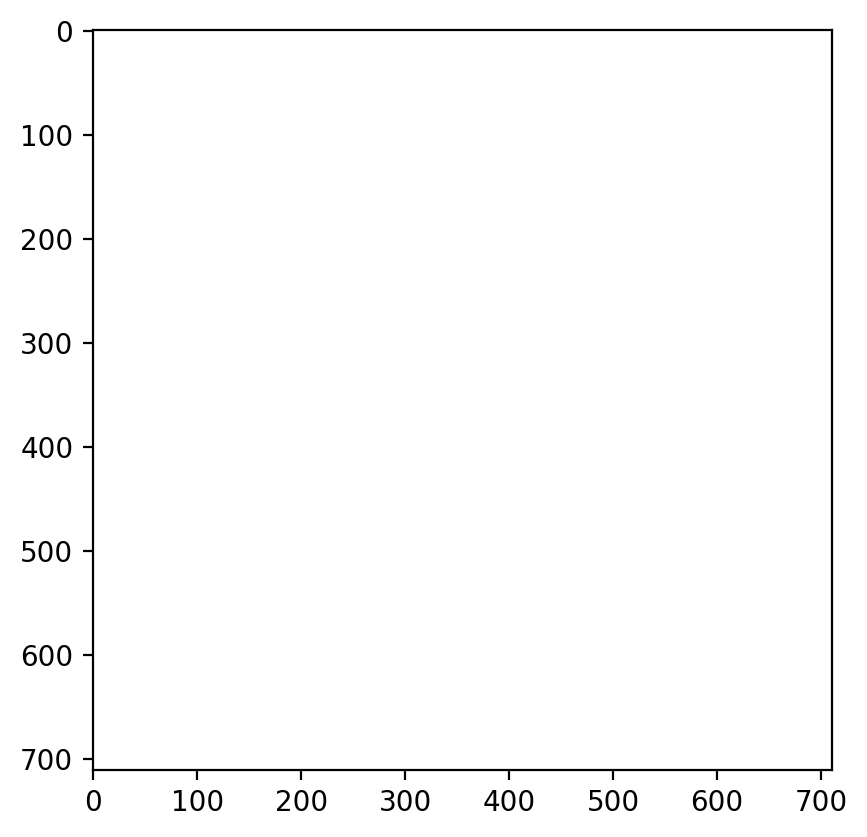

In [30]:
plt.imshow()

In [1]:
x.device

NameError: name 'x' is not defined

In [ ]:
init_sigma/16, 1/(2*d)

(0.23025196866502415, 0.16666666666666666)

In [ ]:
A.shape, x.shape

(torch.Size([400, 400]), torch.Size([400, 3]))

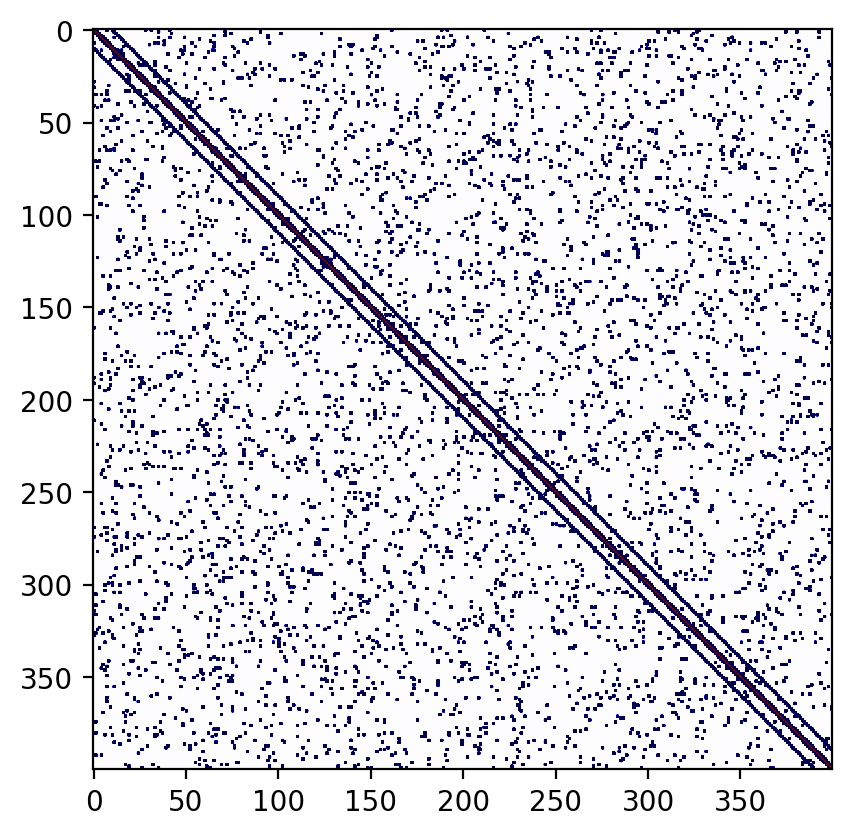

In [ ]:
b = 1e-3
plt.imshow(np.arcsinh(1e3*V(cg_bond_lj.L)), cmap='seismic', vmin=-b, vmax=b)


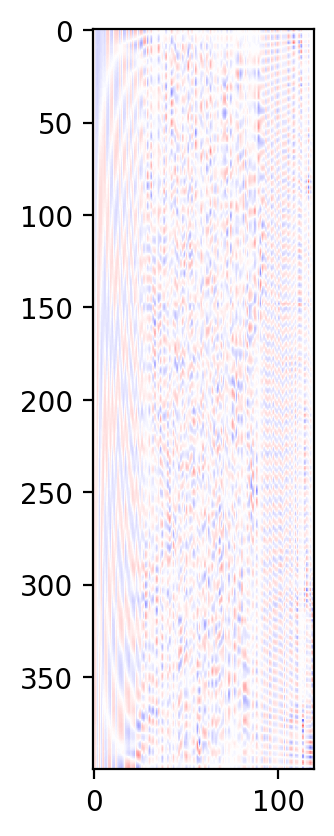

In [ ]:
c = V(cg_bond_lj.cg_modes)
plt.imshow(c, cmap='seismic', vmin=-1, vmax=1) 